# 1. Import Libraries

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
from scipy.stats import expon, reciprocal
from sklearn.metrics import classification_report
import seaborn as sns


# 2. Load Data

In [3]:
drive.mount('/content/drive')



mon_features= pd.read_csv('/content/drive/MyDrive/MLproject/mon_features.csv')
mon_labels = pd.read_csv('/content/drive/MyDrive/MLproject/mon_labels.csv')


Mounted at /content/drive


# 3. Preprocess Data

In [4]:
X = mon_features
y = mon_labels

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data Train/Test Shape:", X_train.shape, X_test.shape)

Data Train/Test Shape: (15200, 27) (3800, 27)


In [6]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Model selection


In [7]:
# Train SVM model
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [8]:
# Define hyperparameter grid for GridSearchCV
param_grid = {
    'C': [100, 200, 300],
    'gamma': [0.1, 0.3],
    'kernel': ['rbf']
}

In [9]:

# Perform GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train_scaled, y_train)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=  28.6s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=  16.9s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=  16.8s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=100, gamma=0.3, kernel=rbf; total time=  20.6s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=100, gamma=0.3, kernel=rbf; total time=  22.3s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=100, gamma=0.3, kernel=rbf; total time=  20.3s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=200, gamma=0.1, kernel=rbf; total time=  18.0s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=200, gamma=0.1, kernel=rbf; total time=  19.5s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=200, gamma=0.1, kernel=rbf; total time=  20.9s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=200, gamma=0.3, kernel=rbf; total time=  21.8s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=200, gamma=0.3, kernel=rbf; total time=  21.1s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=200, gamma=0.3, kernel=rbf; total time=  21.0s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=300, gamma=0.1, kernel=rbf; total time=  18.3s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=300, gamma=0.1, kernel=rbf; total time=  17.1s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=300, gamma=0.1, kernel=rbf; total time=  16.8s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=300, gamma=0.3, kernel=rbf; total time=  20.5s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=300, gamma=0.3, kernel=rbf; total time=  22.2s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=300, gamma=0.3, kernel=rbf; total time=  20.2s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [100, 200, 300], 'gamma': [0.1, 0.3],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [12]:
# Retrieve the best model
best_params = grid_search.best_params_
best_svm_model = grid_search.best_estimator_
best_score = grid_search.best_score_
print(f"Best parameters (GridSearchCV): {best_params}")
print(f"Best score (GridSearchCV): {best_score}")


y_pred = best_svm_model.predict(X_test_scaled)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(95, 95))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Best parameters (GridSearchCV): {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Best score (GridSearchCV): 0.6442112720730525

Accuracy: 0.6744736842105263

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.57      0.55        42
           1       0.72      0.62      0.67        42
           2       0.58      0.86      0.69        35
           3       0.72      0.62      0.67        29
           4       0.74      0.67      0.70        39
           5       0.80      0.80      0.80        45
           6       0.58      0.80      0.67        44
           7       0.63      0.81      0.71        36
           8       0.66      0.56      0.60        34
           9       0.55      0.71      0.62        31
          10       0.70      0.68      0.69        47
          11       0.52      0.63      0.57        35
          12       0.76      0.74      0.75        42
          13       0.28      0.28      0.28        40
          14  

In [14]:
# Define hyperparameter distributions for RandomizedSearchCV
param_distributions = {
    'C': reciprocal(1, 1000),
    'gamma': expon(scale=0.1),
    'kernel': ['rbf'],
    'class_weight': ['balanced', None]
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(SVC(), param_distributions, n_iter=50, cv=2, scoring='accuracy', verbose=2, random_state=50, n_jobs=-1)
random_search.fit(X_train_scaled, y_train)

# Retrieve the best model
best_params_random = random_search.best_params_
best_svm_model_random = random_search.best_estimator_
print(f"Best parameters (RandomizedSearchCV): {best_params_random}")

Fitting 2 folds for each of 50 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters (RandomizedSearchCV): {'C': 536.859007713314, 'class_weight': 'balanced', 'gamma': 0.030500053739212843, 'kernel': 'rbf'}


In [21]:
# Predict using the best model from RandomizedSearchCV
y_pred_random = best_svm_model_random.predict(X_test_scaled)

# Evaluate model performance
accuracy_best = accuracy_score(y_test, y_pred_random)
conf_matrix_best = confusion_matrix(y_test, y_pred_random)
precision = precision_score(y_test, y_pred_random, average='micro')  # 'macro'로 설정
recall = recall_score(y_test, y_pred_random, average='macro')        # 'macro'로 설정

# Calculate ROC and Precision-Recall AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_random, pos_label=1)
roc_auc = auc(fpr, tpr)
precision_values, recall_values, _ = precision_recall_curve(y_test, y_pred_random, pos_label=1)
pr_auc = auc(recall_values, precision_values)

# Display results
print(f"Model Accuracy: {accuracy_best:.4f}")
print(f"Model Precision: {precision:.4f}")
print(f"Model Recall: {recall:.4f}")
print(f"Model ROC AUC: {roc_auc:.4f}")
print(f"Model PR AUC: {pr_auc:.4f}")
print(f"Model Confusion Matrix:")
plt.figure(figsize=(95, 95))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Model Accuracy: 0.6932
Model Precision: 0.6932
Model Recall: 0.6951
Model ROC AUC: 0.2160
Model PR AUC: 0.0067
Model Confusion Matrix:


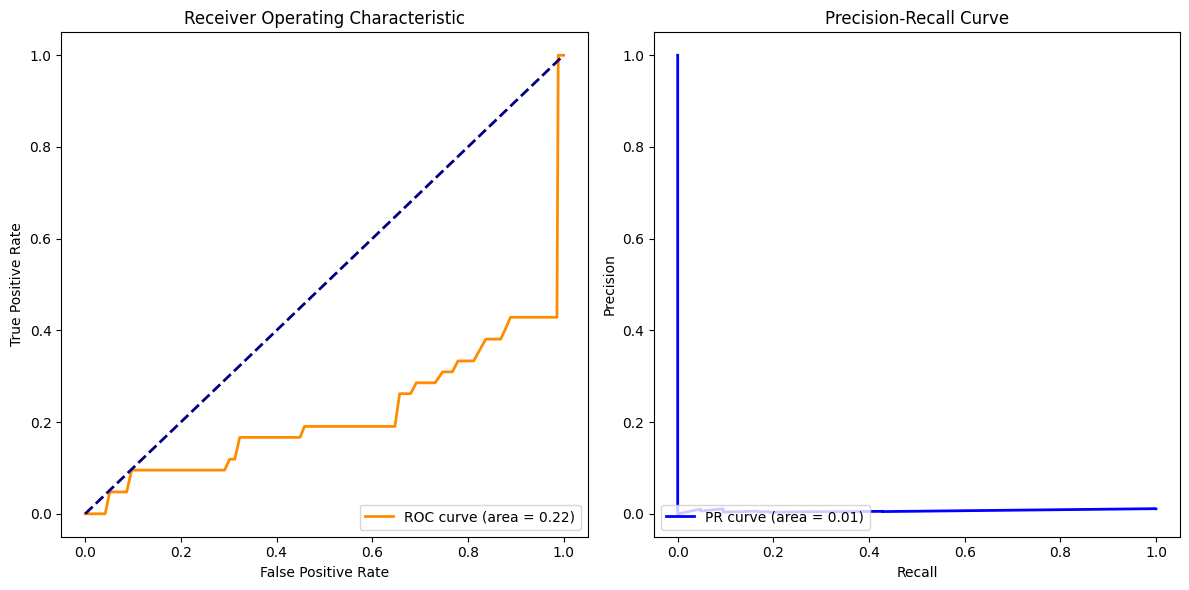

In [22]:
# Plot ROC and Precision-Recall curves
plt.figure(figsize=(12,6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_values, precision_values, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()
